# Lyman alpha fitting

The equation for the cross section is (Diplas \& Savage 1994)

$ \sigma(\lambda) = 4.26e^{-20} \text{cm}^2 / [6.04e^{-10}+ (\lambda - \lambda_0)^2] $

where $\lambda_0 = 1215.67 \AA$. We might need a velocity doppler shift parameter for $\lambda_0$. The model for the spectrum, with $N = N(\text{H I})$ as a parameter, is written as

$ f_m(\lambda; N) = f_c(\lambda) \exp(-N \sigma(\lambda)) $.


The function $f_c(\lambda)$ describes the continuum, the flux without any lines. It is usually a constant or 1st order approximation, determined by fitting or sometimes by eye. $N(\text{HI})$ can be found by minimizing a $\chi^2$ function

$ \chi^2(N) = \frac{1}{n - 1} \sum_i \sigma
_c^{-1} (f_i - f_m(\lambda_i; N))^2$. 

Here, a suitable noise model $\sigma_c$ needs to be chosen. In DS94, $\sigma_c = \text{constant} \times \exp(\sigma(\lambda_i) N)$. This is not an error on the measurement, but rather a factor to treat the other features of the spectrum as noise. For the constant, they use the RMS deviation with respect to $f_c$, over a wavelength range outside the line, deemed to have similar noise as the line wings. 

The workflow goes as follows:
1. Find a suitable approximation for the continuum.
2. Find a suitable noise level with respect to the continuum.
2. Mask wavelengths that have troublesome features.
3. Optimize the $\chi^2$ function for the remaining data points $(\lambda_i, f_i)$, minimizing the differences between $f_i$ and $f_m(\lambda_i)$.


In [3]:
def sigma(l):
    l0 = 1215.67
    return 4.26e-20 / (6.04e-10 + np.square(l - l0))
    
def fmodel(fcontinuum, NHI):
    return lambda l : fcontinuum(l) * np.exp(-NHI * sigma(l))

def chi2(NHI, fc, sigma_c, wavs, fs):
    extinctions = np.exp(NHI * sigma(l))
    deltas = fc(wavs) - fs * extinctions
    sigmas = sigma_c * extinctions
    chi2 = np.square((deltas / sigmas)).sum() / (len(deltas) - 1)
    return chi2


In [26]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 226

%matplotlib inline

def prepare_axes():
    plt.xlabel('wavelength')
    plt.ylabel('flux (erg cm$^{-2}$s$^{-1}\\AA^{-1}$)')
    
def plot_iue_order(table, index):
    data_column_name = 'ABS_CAL'
    flux = table[index][data_column_name]
    wavs = [table[index]['WAVELENGTH'] + table[index]['DELTAW'] * i for i in range(len(flux))]
#    dq = table[index]['QUALITY']
 #   good = dq == -2  
  #  plt.plot(wavs[good], flux[good])
    plt.plot(wavs, flux)
    
def plot_stis_order(table, index):
    wavs = table[index]['WAVELENGTH']
    data_column_name = 'FLUX'
    flux = table[index][data_column_name]
    plt.plot(wavs, flux)
    
def plot_function_at_lya(f, ylabel='f(x)', *args):
    x = np.linspace(1100, 1300, 1000)
    y = f(x, *args)
    plt.xlabel('wavelength')
    

## Data exploration

In [27]:
# open some data
from astropy.io import fits
from astropy.table import Table
from pathlib import Path

In [28]:
def sort_by_wav(wavs, flux):
    idxs = np.argsort(wavs)
    return wavs[idxs], flux[idxs]

### STIS data looks like this

In [29]:
spectrum_file = '/Users/dvandeputte/Projects/FUSE H2/plotting_git/data/HD094493/mastDownload/HST/o54306010/o54306010_x1d.fits'
fits.info(spectrum_file)

Filename: /Users/dvandeputte/Projects/FUSE H2/plotting_git/data/HD094493/mastDownload/HST/o54306010/o54306010_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     294   ()      
  1  SCI           1 BinTableHDU    157   52R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


In [30]:
t = Table.read(spectrum_file)
t

SPORDER,NELEM,WAVELENGTH [1024],GROSS [1024],BACKGROUND [1024],NET [1024],FLUX [1024],ERROR [1024],NET_ERROR [1024],DQ [1024],A2CENTER,EXTRSIZE,MAXSRCH,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST,EXTRLOCY [1024],OFFSET
,,Angstroms,Counts/s,Counts/s,Counts/s,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),Counts/s,,pix,pix,pix,pix,pix,pix,pix,pix,pix
int16,int16,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32
311,1024,1350.747921548162 .. 1356.850121451195,-6.138127e-06 .. 1.558715,0.02532305 .. 0.02835393,-0.02532918 .. 1.530361,-2.742387e-12 .. 1.224867e-10,9.557633e-19 .. 2.829744e-12,8.827604e-09 .. 0.03535509,2564 .. 2564,975.5471,7,10,5,5,-11.1656,11.16562,978.0134 .. 973.0856,0.08340175
312,1024,1346.410244888081 .. 1352.4926673921,-6.138127e-06 .. 2.722371,0.02633303 .. 0.0329361,-0.02633917 .. 2.689435,-2.490436e-12 .. 1.86509e-10,8.346726e-19 .. 3.240248e-12,8.827604e-09 .. 0.04672393,2564 .. 2564,953.2839,7,10,5,5,-11.095,11.09502,955.8002 .. 950.7726,0.05422524
313,1024,1342.100161580133 .. 1348.16290768566,-6.138127e-06 .. 2.01172,0.02612872 .. 0.03576207,-0.02613486 .. 1.975958,-2.258255e-12 .. 1.232868e-10,7.627735e-19 .. 2.50605e-12,8.827604e-09 .. 0.0401653,2564 .. 2564,931.178,7,10,5,5,-11.0251,11.02514,933.744 .. 928.6172,0.03742611
314,1024,1337.817409333146 .. 1343.860579312885,-6.138127e-06 .. 1.721681,0.02911996 .. 0.0351702,-0.0291261 .. 1.68651,-2.424509e-12 .. 9.965075e-11,7.348257e-19 .. 2.195513e-12,8.827604e-09 .. 0.03715732,2564 .. 2564,909.2513,7,10,5,5,-10.956,10.95597,911.8664 .. 906.6412,0.0561737
315,1024,1333.561729173103 .. 1339.585422578695,-6.138127e-06 .. 3.443774,0.02829671 .. 0.03849363,-0.02830285 .. 3.40528,-2.330373e-12 .. 1.959344e-10,7.268388e-19 .. 3.023705e-12,8.827604e-09 .. 0.05255108,2564 .. 2564,887.4185,7,10,5,5,-10.8875,10.88749,890.0827 .. 884.7596,0.02684189
316,1024,1329.332865390879 .. 1335.337181059502,-6.138127e-06 .. 1.181984,0.02893804 .. 0.03234684,-0.02894418 .. 1.149637,-2.391438e-12 .. 6.526903e-11,7.29358e-19 .. 1.747931e-12,8.827604e-09 .. 0.03078775,2564 .. 2564,865.7549,7,10,5,5,-10.8197,10.8197,868.4677 .. 863.0474,0.02599614
317,1024,1325.130565490814 .. 1331.115601551806,-6.138127e-06 .. 2.128347,0.03059974 .. 0.0406127,-0.03060588 .. 2.087735,-2.551874e-12 .. 1.177995e-10,7.360328e-19 .. 2.331073e-12,8.827604e-09 .. 0.04131312,2564 .. 2564,844.1549,7,10,5,5,-10.7526,10.75257,846.9161 .. 841.3992,-0.05033708
318,1024,1320.954580140388 .. 1326.920434021724,-6.138127e-06 .. 2.081517,0.03169031 .. 0.0416286,-0.03169645 .. 2.039888,-2.681354e-12 .. 1.150198e-10,7.46769e-19 .. 2.303685e-12,8.827604e-09 .. 0.04085609,2564 .. 2564,822.7504,7,10,5,5,-10.6861,10.68611,825.5596 .. 819.9467,-0.06905999


In [31]:
t['ERROR'][20]

masked_array(data=[9.539074741307189e-19, 7.652660623247431e-12,
                   2.509131574388035e-12, ..., 1.2035910462726562e-12,
                   1.6853768814578673e-12, 2.279012915884504e-12],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [32]:
import numpy as np
def stis_merge_orders(t, extra_columns=None):
    """
    Put the data from all spectral orders of a set of STIS data into one big array
    
    t: Table containing STIS data
    
    extra_columns: list of strings, indicating columns other than 'WAVELENGTH' and 'FLUX' to be merged and sorted
    
    Returns
    -------
        allwavs, allflux: ndarray, wavelengths and fluxes, sorted by wavelength
        
        list of arrays: if extra_columns is not None, the requested columns merged and sorted in the same way
    """
    allwavs = np.concatenate(t['WAVELENGTH'])
    allflux = np.concatenate(t['FLUX'])
    idxs = np.argsort(allwavs)
    
    if extra_columns is None:
        return allwavs[idxs], allflux[idxs]
    else:    
        extras = []
        for name in extra_columns:
            if not isinstance(t[name], np.ndarray):
                print("This STIS data column does not have per-wavelength data: ", name)
                raise
            extras.append(np.concatenate(t[name]))
        return allwavs[idxs], allflux[idxs], [array[idxs] for array in extras]

def stis_binned(t, numbins):
    wavmin = 1150
    wavmax = 1280
    wavbins = np.linspace(wavmin, wavmax, numbins, endpoint=True)

    wavs, flux, (errs,) = stis_merge_orders(t, extra_columns=['ERROR'])
    
    # np.digitize returns list of indices. 1 means that the data point is between wav[0] (first) and wav[1]
    # n-1 means between wav[n-2] and wav[n-1] (last). 0 and n mean out of range.
    bs = np.digitize(wavs, wavbins)
    newwavs = np.zeros(len(wavbins) - 1)
    newflux = np.zeros(len(wavbins) - 1)
    for i in range(0, len(wavbins) - 1): 
        b = i + 1 # from 1 to n-1
        in_bin = bs == i+1
        
        weights = 1 / np.square(errs[in_bin])
        newwavs[i] = np.average(wavs[in_bin], weights=weights)
        newflux[i] = np.average(flux[in_bin], weights=weights)
        
    return newwavs, newflux
    

/Users/dvandeputte/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
<ipython-input-32-5a40e05ef52c>:48: UserWarning: Warning: converting a masked element to nan.
  newwavs[i] = np.average(wavs[in_bin], weights=weights)
<ipython-input-32-5a40e05ef52c>:49: UserWarning: Warning: converting a masked element to nan.
  newflux[i] = np.average(flux[in_bin], weights=weights)


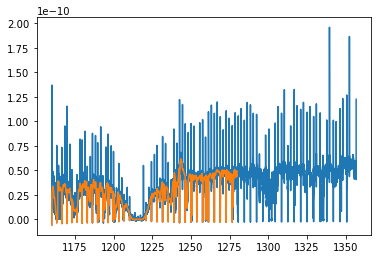

In [33]:
# try plotting this
x, y = stis_merge_orders(t)
xbin, ybin = stis_binned(t, 1000)
plt.plot(x, y)
plt.plot(xbin, ybin)

### IUE high res like this

In [38]:
spectrum_file = '/Users/dvandeputte/Projects/FUSE H2/plotting_git/data/HD197770/swp49267.mxhi.gz'
fits.info(spectrum_file)

Filename: /Users/dvandeputte/Projects/FUSE H2/plotting_git/data/HD197770/swp49267.mxhi.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     434   ()      
  1  MEHI          1 BinTableHDU     61   60R x 17C   [1B, 1I, 1D, 1I, 1D, 1E, 1E, 768E, 768E, 768E, 768I, 768E, 768E, 1I, 1I, 1E, 7E]   


In [39]:
t = Table.read(spectrum_file)
t

ORDER,NPOINTS,WAVELENGTH,STARTPIX,DELTAW,SLIT HEIGHT,LINE_FOUND,NET [768],BACKGROUND [768],NOISE [768],QUALITY [768],RIPPLE [768],ABS_CAL [768],START-BKG,END-BKG,SCALE_BKG,COEFF [7]
,,ANGSTROM,PIXEL,ANGSTROM,PIXEL,PIXEL,FN,FN,FN,,FN,ERG/CM2/S/A,PIXEL,PIXEL,,
uint8,int16,float64,int16,float64,float32,float32,float32,float32,float32,int16,float32,float32,int16,int16,float32,float32
125,532,1097.3169813308818,116,0.028543843462381435,4.079994,128.39,0.0 .. 0.0,84.66054 .. 87.43197,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,274,493,172.47168,7.0865216 .. 0.0
124,542,1106.0037572528506,111,0.028762647437967387,4.080002,132.99,0.0 .. 0.0,84.386856 .. 87.46859,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,193,559,325.6137,3.6561356 .. 0.0
123,550,1114.8617652625421,107,0.028985153803489094,4.080002,137.76,0.0 .. 0.0,84.48971 .. 87.43659,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,220,559,241.53601,5.032422 .. 0.0
122,558,1123.8659401337761,103,0.02921146477391005,4.080002,142.7,0.0 .. 0.0,84.233 .. 87.4565,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,166,604,383.0404,3.096445 .. 0.0
121,568,1132.9904336297634,98,0.029441685943266932,4.080002,147.82,0.0 .. 0.0,84.051 .. 87.49953,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,166,628,395.49884,3.004145 .. 0.0
120,576,1142.2976079345299,94,0.029675926403465114,4.080002,153.12,0.0 .. 0.0,84.63915 .. 87.580826,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,139,652,412.67572,2.8236604 .. 0.0
119,586,1151.7321749668185,89,0.02991429903756769,4.080002,158.92,0.0 .. 0.0,87.16516 .. 87.54254,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,139,652,426.88086,2.7345126 .. 0.0
118,592,1161.3878450792374,86,0.030156920433098696,4.080002,164.8,0.0 .. 0.0,90.53308 .. 87.42347,0.0 .. 0.0,-2 .. -2,0.0 .. 0.0,0.0 .. 0.0,112,679,440.25604,2.6517665 .. 0.0


In [40]:
# check the contents of one row
row = 1
print(t[row]['WAVELENGTH'])
t[row]['NET'].shape
dq = t[row]['QUALITY']
dq == -2

1106.0037572528506


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [41]:
def iue_h_merge_orders(t):
    
    def iue_wavs(i):
        return t[i]['WAVELENGTH'] + t[i]['DELTAW'] * np.arange(t[i]['NPOINTS'])
    
    def iue_flux(i):
        pixrange = slice(t[i]['STARTPIX'], t[i]['STARTPIX'] + t[i]['NPOINTS'])
        return t[i]['ABS_CAL'][pixrange]
    
    allwavs = np.concatenate([iue_wavs(i) for i in range(len(t))])
    allflux = np.concatenate([iue_flux(i) for i in range(len(t))])
    
    return sort_by_wav(allwavs, allflux)

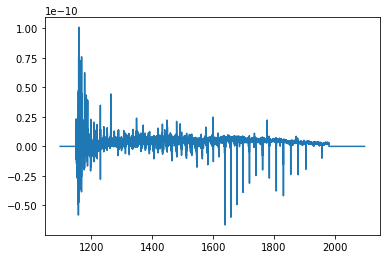

In [42]:
allwavs, allflux = iue_h_merge_orders(t)
plt.plot(allwavs, allflux)

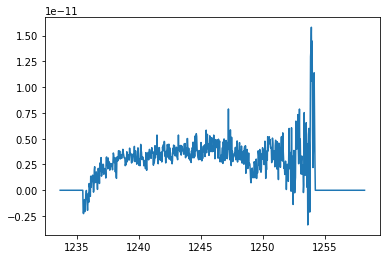

In [74]:
# separate orders
#for i in range(1, 30):
#    plot_iue_order(t, i)
    
plot_iue_order(t, 14)

### IUE low res

In [58]:
spectrum_file = "/Users/dvandeputte/Projects/FUSE H2/plotting_git/data/BD+52d3210/swp34153mxlo_vo.fits"
t = Table.read(spectrum_file)
t

WAVE [495],FLUX [495],SIGMA [495],QUALITY [495]
Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),
float32,float32,float32,int16
1150.5887 .. 1978.7046,2.1455602e-12 .. 1.1352243e-12,4.0577562e-13 .. 2.348361e-14,0 .. 0
